In this notebook we are going to compute different connectivity measures and aggregate them into a dataframe. 

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import mne
import mne_connectivity
import pactools
from mne_connectivity import phase_slope_index, seed_target_indices, spectral_connectivity_epochs
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import fooof
# Import plotting functions
from fooof.plts.spectra import plot_spectrum, plot_spectra
# Import the FOOOF object
from fooof import FOOOF
from fooof import FOOOFGroup
import os 
import joblib
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pickle
from tqdm import tqdm
from IPython.display import clear_output
import warnings 

# I only want to see warnings once
warnings.filterwarnings('ignore')

from joblib import delayed, Parallel
from statsmodels.stats import multitest

Note: If you have installed this package in editable form on Minerva, you must append the local path! This is because Minerva requires that you point your package installs away from the local directory for space reasons, but editable packages have to be installed locally.

In [3]:
import sys
sys.path.append('/hpc/users/qasims01/resources/LFPAnalysis')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils, oscillation_utils, statistics_utils


## First, get the behavior data

This is from another notebook with a kernel and environment specifically for beahvior

In [5]:
base_dir = '/sc/arion' # this is the root directory for most un-archived data and results
load_dir = f'{base_dir}/work/qasims01/MemoryBanditData/EMU'

# Load the demographics data to get information about who has run the task
demo_file = f'{base_dir}/projects/guLab/Salman/EMU/MemoryBanditsDatabase.xlsx'
demo_data = pd.read_excel(demo_file, engine='openpyxl')
subj_df = demo_data[(demo_data.LongVersion==1) & (demo_data.Minerva==1)]

# Let's get rid of Iowa patients for now 

# subj_df = subj_df[subj_df.Site=='UI']
subj_df = subj_df[~subj_df['MSSMCode'].isin(['UI002', 'MS024', 'MS034', 'MS038'])]


days = ['Day1', 'Day2']
subj_ids = subj_df.MSSMCode.values
subj_formats = subj_df.format.values
subj_sites = subj_df.Site.values
subj_days = subj_df.Day2.values

In [6]:
# load behavioral data
learn_df = pd.read_csv(f'{load_dir}/learn_df.csv')
combined_df = pd.read_csv(f'{load_dir}/combined_df.csv')
full_data_df = pd.read_csv(f'/sc/arion/work/qasims01/MemoryBanditData/EMU/full_df.csv')


# Filter just to the participants in this notebook
learn_df = learn_df[learn_df.participant.isin(subj_ids)]
combined_df = combined_df[combined_df.participant.isin(subj_ids)]


# I enter the day information in stupidly 
combined_df.condition = combined_df.condition.apply(lambda x: 'Day1' if x=='day_1' else 'Day2' if x=='day_2' else np.nan)
combined_df['recog_time'] = combined_df['recog_time'].apply(lambda x: float(x) if (~pd.isna(x)) & (x!='None') else x)
combined_df['baseline_start_mem'] = combined_df['baseline_start_mem'].apply(lambda x: float(x) if (~pd.isna(x)) & (x!='None') else x)

# # add RPE to the combined df dataframe: 

combined_df['rpe'] = np.nan
full_data_df['rpe'] = np.nan

for ix, row in learn_df.iterrows():
    combined_df.loc[(combined_df.img_path==row.img_path) & (combined_df.participant==row.participant), 'rpe'] = row.rpe
    full_data_df.loc[(full_data_df.img_path==row.img_path) & (full_data_df.participant==row.participant), 'rpe'] = row.rpe


## PSI computation: 

In [7]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict

evs = {'gamble_start':[-1.0, 0], 
       'feedback_start': [0, 1.5],
       'baseline_start': [0, 0.75]}

baseline_ev = 'baseline_start'
analysis_evs = ['feedback_start']

day = 'Day1'

for i in analysis_evs: 
    if i not in evs.keys(): 
        raise ValueError('This analysis event is not in the dictionary')

Instead of computing surrogate values, perhaps I should normalize this relative to the baseline period. 

In [ ]:
# choose the connectivity metric
metric = 'coh'  # ['coh', 'mic', 'mim', 'plv', 'ciplv', 'pli', 'wpli', 'gc', 'gc_tr']

band_dict = {'theta' : [2, 9],
               'beta' : [14, 30]}

freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = np.floor(np.logspace(*np.log10([3, 10]), num=30))

buf_ms = 1000
n_surr = 500

source_region = 'HPC'

# source_region = 'dmPFC'
# ['OFC', 'ACC', 'AMY']
# source_region = 'OFC'
# ['ACC', 'AMY']
# source_region = 'ACC'
# ['AMY']

# iterate through target regions
# analysis_evs = ['baseline_start']
analysis_evs = ['feedback_start', 'recog_time']


for target_region in ['OFC', 'AMY']: 
    conn_group_data = []

    for subj_id in subj_ids:

        filepath = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/scratch/PSI'
        if not os.path.exists(filepath):
            os.makedirs(filepath)

        for event in analysis_evs:
            save_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/neural/{day}'
            epochs_reref = mne.read_epochs(f'{save_path}/{event}-epo.fif', preload=True) 
            
            # NAN out the bad data
            # THE following will now LOAD in dataframes that indicate IED and artifact time points in your data
            IED_df = pd.read_csv(f'{save_path}/{event}_IED_df.csv') 
            artifact_df = pd.read_csv(f'{save_path}/{event}_artifact_df.csv') 

            # Now, let's iterate through each channel, and each ied/artifact, and NaN 100 ms before and after these timepoints
            for ch_ix, ch_name in enumerate(epochs_reref.ch_names): 
                ied_ev_list = IED_df[ch_name].dropna().index.tolist()
                artifact_ev_list = artifact_df[ch_name].dropna().index.tolist() 
                for ev_ in ied_ev_list: 
                    for ied_ in literal_eval(IED_df[ch_name].iloc[ev_]):
                        # remove 100 ms before 
                        ev_ix_start = np.max([0, np.floor((ied_- 0.1) * epochs_reref.info['sfreq'])]).astype(int)
                        # remove 100 ms after
                        ev_ix_end = np.min([epochs_reref._data.shape[-1], np.ceil((ied_ + 0.1) * epochs_reref.info['sfreq'])]).astype(int)
                        epochs_reref._data[ev_, ch_ix, ev_ix_start:ev_ix_end] = np.nan
                for ev_ in artifact_ev_list: 
                    for artifact_ in literal_eval(artifact_df[ch_name].iloc[ev_]):
                        # remove 100 ms before 
                        ev_ix_start = np.max([0, np.floor((artifact_- 0.1) * epochs_reref.info['sfreq'])]).astype(int)
                        # remove 100 ms after
                        ev_ix_end = np.min([epochs_reref._data.shape[-1], np.ceil((artifact_ + 0.1) * epochs_reref.info['sfreq'])]).astype(int)
                        epochs_reref._data[ev_, ch_ix, ev_ix_start:ev_ix_end] = np.nan

            # Get electrode df 
            elec_df = pd.read_csv(f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/Day1_reref_elec_df')

            # construct the seed-to-target mapping based on your rois - matters most for PSI as this is directional 
            seed_target_df = pd.DataFrame(columns=['seed', 'target'], index=['l', 'r'])
            for hemi in ['l', 'r']:
                seed_target_df['seed'][hemi] = np.where(elec_df.loc[elec_df.hemisphere==hemi, 'salman_region'] == source_region)[0]
#                 seed_target_df['target'][hemi] = np.where(elec_df.loc[elec_df.hemisphere==hemi, 'salman_region'].isin(target_regions))[0]    

                seed_target_df['target'][hemi] = np.where(elec_df.loc[elec_df.hemisphere==hemi, 'salman_region'] == target_region)[0]    

            seed_target_df = seed_target_df[
                        (seed_target_df['seed'].map(lambda d: len(d) > 0)) & (seed_target_df['target'].map(lambda d: len(d) > 0))]


            # for cond in conditions: 
            for hemi in ['l', 'r']:
                # first determine if ipsi connectivity is even possible; if not, move on
                if hemi not in seed_target_df.index.tolist():
                    continue
                else:
                    seed_to_target = seed_target_indices(
                        seed_target_df['seed'][hemi],
                        seed_target_df['target'][hemi])
                    
                
                    
                # These epochs only grab those images that were later involved in memory recognition:
                if event in ['gamble_start', 'feedback_start', 'baseline_start']:
                    epochs_to_analyze = combined_df[(combined_df.participant==subj_id) & (combined_df.condition=='Day1')].dropna(subset=['trials_gamble']).sort_values(by='trials_gamble').reset_index(drop=True).trials_gamble.values - 1
                elif event == 'recog_time': 
                    epochs_to_analyze = combined_df[(combined_df.participant==subj_id) & (combined_df.condition=='Day1')].dropna(subset=['trials_gamble']).sort_values(by='trials_mem').reset_index(drop=True).trials_mem.values - 1
                    
                trunc_epochs = epochs_reref[epochs_to_analyze.astype(int)]
                
                avg_dim = 'time'
                
                # NOTE: If I compute any epoch-avged connectivity measures, I need to NAN bad epochs BEFORE hand 
                npairs = len(seed_to_target[0])
                
#                 for pair in range(npairs): 
#                     source_bad_epochs  = list(np.where(trunc_epochs.metadata[trunc_epochs.ch_names[seed_to_target[0][pair]]].notnull())[0])
#                     target_bad_epochs  = list(np.where(trunc_epochs.metadata[trunc_epochs.ch_names[seed_to_target[1][pair]]].notnull())[0])
#                     bad_epochs = np.array(source_bad_epochs+target_bad_epochs)
#                     channels_involved = np.concatenate([np.unique(x) for x in seed_to_target])
#                     trunc_epochs._data[bad_epochs[:, np.newaxis], channels_involved, :] = 0
                
                pwise_dfs = []
                for band in band_dict.keys():
                
                    pwise = oscillation_utils.compute_connectivity(trunc_epochs, 
                                                               band = band_dict[band], 
                                                               metric = metric, 
                                                               indices = seed_to_target, 
                                                               freqs = freqs, 
                                                               n_cycles = n_cycles,
                                                               buf_ms = buf_ms, 
                                                               n_surr=n_surr,
                                                               avg_over_dim=avg_dim)

                    if avg_dim == 'epoch':
                        pwise = pwise[:, int(buf_ms  * (epochs_reref.info['sfreq']/1000)):-int(buf_ms  * (epochs_reref.info['sfreq']/1000))]

                    for pair in range(npairs): 
                        pwise_df = pd.DataFrame(columns=['participant', 'roi1', 'roi2', 'hemi', 'pair_label', 'metric', 'event', 'conn'])
                        pwise_df['conn'] = pwise[:, pair] 
                        pwise_df['participant'] = subj_id
                        pwise_df['age'] = subj_df[subj_df.MSSMCode==subj_id].Age.values[0]
                        pwise_df['sex'] = subj_df[subj_df.MSSMCode==subj_id].Sex.str.strip().values[0]

                        pwise_df['roi1'] = source_region
                        pwise_df['roi2'] = target_region
                        pwise_df['hemi'] = hemi 
                        pwise_df['metric'] = metric 
                        pwise_df['event'] = event
                        pwise_df['band'] = band
                        pwise_df['pair_label'] = f'{epochs_reref.ch_names[seed_to_target[0][pair]]}:{epochs_reref.ch_names[seed_to_target[1][pair]]}'
                        # pwise_df['trials'] = np.arange(1, pwise.shape[0]+1)
                        if event in ['gamble_start', 'feedback_start', 'baseline_start']:
                            pwise_df['trials_gamble'] = combined_df[(combined_df.participant==subj_id) & (combined_df.condition=='Day1')].dropna(subset=['trials_gamble']).sort_values(by='trials_gamble').reset_index(drop=True).trials_gamble.values
                            pwise_df = pwise_df.merge(combined_df[(combined_df.participant==subj_id) & (combined_df.condition=='Day1')].dropna(subset=['trials_gamble']).sort_values(by='trials_gamble').reset_index(drop=True), 
                                                      on=['participant', 'trials_gamble'])
                        elif event == 'recog_time':
                            pwise_df['trials_mem'] = combined_df[(combined_df.participant==subj_id) & (combined_df.condition=='Day1')].dropna(subset=['trials_gamble']).sort_values(by='trials_mem').reset_index(drop=True).trials_mem.values
                            pwise_df = pwise_df.merge(combined_df[(combined_df.participant==subj_id) & (combined_df.condition=='Day1')].dropna(subset=['trials_gamble']).sort_values(by='trials_mem').reset_index(drop=True), 
                                                      on=['participant', 'trials_mem'])

                        pwise_df['zrpe'] = (pwise_df.rpe - np.nanmean(pwise_df.rpe)) / (2*np.nanstd(pwise_df.rpe))
                        pwise_df['zpm'] = (pwise_df.DPRIME - np.nanmean(pwise_df.DPRIME)) / (2*np.nanstd(pwise_df.DPRIME))


#                         pwise_df['good_epoch'] = 1
#                         # NOTE: HOW TO HANDLE BAD EPOCHS? 
#                         # for ch_ix in progress_bar: 
#                         source_bad_epochs  = list(np.where(epochs_reref.metadata[epochs_reref.ch_names[seed_to_target[0][pair]]].notnull())[0])
#                         target_bad_epochs  = list(np.where(epochs_reref.metadata[epochs_reref.ch_names[seed_to_target[1][pair]]].notnull())[0])
#                         bad_epochs = np.array(source_bad_epochs+target_bad_epochs)
#                         if event in ['gamble_start', 'feedback_start', 'baseline_start']:
#                             pwise_df.loc[pwise_df['trials_gamble'].isin(bad_epochs), 'good_epoch'] = 0
#                         elif event == 'recog_time':
#                             pwise_df.loc[pwise_df['trials_mem'].isin(bad_epochs), 'good_epoch'] = 0
                            
                        # aggregate
                        pwise_dfs.append(pwise_df)
                pwise_dfs = pd.concat(pwise_dfs)
                conn_group_data.append(pwise_dfs)

    all_pairs_df = pd.concat(conn_group_data)
    all_pairs_df.to_csv(f'/sc/arion/projects/guLab/Salman/EphysAnalyses/Connectivity/{source_region}_{target_region}_{metric}_df', index=False)



Computing surrogate # 471
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated


In [8]:
source_region = 'HPC'
target_region = 'OFC'
metric = 'coh'
all_pairs_df = pd.read_csv(f'/sc/arion/projects/guLab/Salman/EphysAnalyses/Connectivity/{source_region}_{target_region}_{metric}_df')



In [164]:
bp_sig1 = mne.filter.filter_data(sig1, 
                                 trunc_epochs.info['sfreq'], 
                                 l_freq=2, 
                                 h_freq=10)

Setting up band-pass filter from 2 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [165]:
bp_sig2 = mne.filter.filter_data(sig2, 
                                 trunc_epochs.info['sfreq'], 
                                 l_freq=2, 
                                 h_freq=10)

Setting up band-pass filter from 2 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


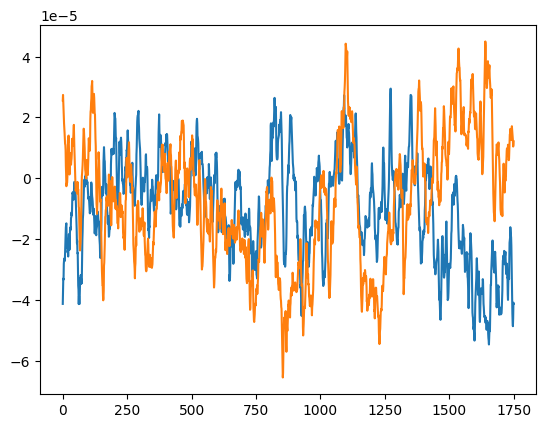

In [166]:
plt.plot(trunc_epochs._data[22, 0])
plt.plot(trunc_epochs._data[33, 0])

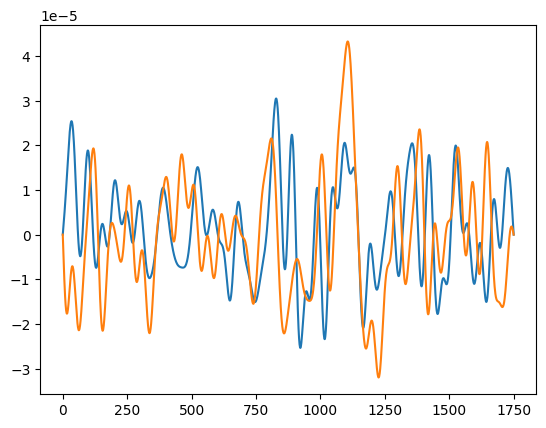

In [167]:
plt.plot(bp_sig1)
plt.plot(bp_sig2)

In [151]:
pwise = oscillation_utils.compute_connectivity(trunc_epochs, 
                                                           band = band, 
                                                           metric = metric, 
                                                           indices = seed_to_target_new, 
                                                           freqs = freqs, 
                                                           n_cycles = n_cycles,
                                                           buf_ms = buf_ms, 
                                                           n_surr=n_surr,
                                                           avg_over_dim=avg_dim)

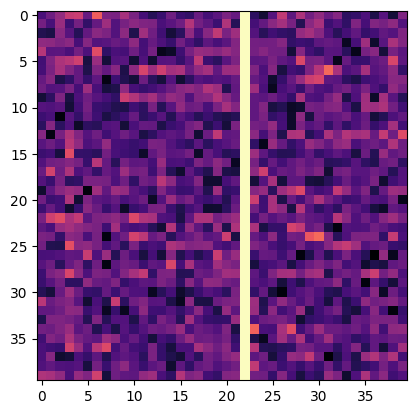

In [154]:
plt.imshow(pwise, cmap='magma')


In [9]:
all_pairs_df['phit'] = all_pairs_df['hits'].astype(int) - 0.5

In [12]:
model_df = all_pairs_df[all_pairs_df.good_epoch==1]

In [18]:
test_mod = smf.mixedlm(formula='conn ~ 1 + zrpe + zpm + C(phit) + zrpe:C(phit) + zpm:C(phit)', 
                       data=all_pairs_df, 
                       re_formula="zrpe + zpm + C(phit) + zrpe:C(phit) + zpm:C(phit)",
                       groups=all_pairs_df['pair_label']).fit()

#                        re_formula="zrpe + zpm + C(phit) + zrpe:C(phit) + zpm:C(phit)",


In [19]:
test_mod.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Mixed Linear Model Regression Results
=======================================================================================
Model:                      MixedLM           Dependent Variable:           conn       
No. Observations:           48640             Method:                       REML       
No. Groups:                 240               Scale:                        1.0208     
Min. group size:            160               Log-Likelihood:               -70121.8073
Max. group size:            800               Converged:                    No         
Mean group size:            202.7                                                      
---------------------------------------------------------------------------------------
                                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------
Intercept                                     0.080    0.012  6.522 0.000  0.056  0.104
C(phit)[T.0.5]                                0.022    0.016  1.335 0.182 -0.010  0.053
zrpe                                          0.003    0.016  0.202 0.840 -0.029  0.035
zrpe:C(phit)[T.0.5]                           0.015    0.021  0.704 0.481 -0.027  0.056
zpm                                          -0.003    0.017 -0.178 0.858 -0.036  0.030
zpm:C(phit)[T.0.5]                           -0.004    0.021 -0.191 0.849 -0.046  0.038
Group Var                                     0.021    0.002                           
Group x C(phit)[T.0.5] Cov                    0.006    0.003                           
C(phit)[T.0.5] Var                            0.037                                    
Group x zrpe Cov                             -0.002    0.002                           
C(phit)[T.0.5] x zrpe Cov                     0.002    0.006                           
zrpe Var                                      0.016    0.003                           
Group x zrpe:C(phit)[T.0.5] Cov               0.003    0.004                           
C(phit)[T.0.5] x zrpe:C(phit)[T.0.5] Cov      0.001    0.009                           
zrpe x zrpe:C(phit)[T.0.5] Cov                0.015                                    
zrpe:C(phit)[T.0.5] Var                       0.015    0.013                           
Group x zpm Cov                              -0.001    0.002                           
C(phit)[T.0.5] x zpm Cov                      0.001    0.007                           
zrpe x zpm Cov                               -0.003    0.007                           
zrpe:C(phit)[T.0.5] x zpm Cov                -0.003    0.010                           
zpm Var                                       0.017    0.013                           
Group x zpm:C(phit)[T.0.5] Cov                0.001    0.004                           
C(phit)[T.0.5] x zpm:C(phit)[T.0.5] Cov      -0.002    0.010                           
zrpe x zpm:C(phit)[T.0.5] Cov                 0.002    0.008                           
zrpe:C(phit)[T.0.5] x zpm:C(phit)[T.0.5] Cov  0.002    0.015                           
zpm x zpm:C(phit)[T.0.5] Cov                  0.015    0.004                           
zpm:C(phit)[T.0.5] Var                        0.020    0.024                           
=======================================================================================

"""

In [96]:
test_mod.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:                MixedLM   Dependent Variable:   conn    
No. Observations:     405       Method:               REML    
No. Groups:           17        Scale:                0.0214  
Min. group size:      18        Log-Likelihood:       186.4284
Max. group size:      50        Converged:            Yes     
Mean group size:      23.8                                    
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.451    0.012 39.072 0.000  0.429  0.474
C(phit)[T.0.5]       0.023    0.015  1.512 0.130 -0.007  0.052
zrpe                 0.019    0.020  0.967 0.334 -0.020  0.059
zrpe:C(phit)[T.0.5] -0.005    0.029 -0.188 0.851 -0.062  0.052
zpm                 -0.004    0.021 -0.211 0.833 -0.046  0.037
zpm:C(phit)[T.0.5]  -0.021    0.028 -0.725 0.468 -0.076  0.035
Group Var            0.000    0.003                           
==============================================================

"""

HPC-OFC theta (2-5 Hz) wPLI is significantly up-regulated by RPE alone (good epochs only). Coherence even more so. However, nothing happens during recognition.

This is not true of HPC-AMY theta wPLI. Nothing happens during recognition either. 

Nor of OFC-AMY theta wPLI. Nothing happens during recognition either. 

This is also true of ACC-AINS 2-5 Hz coh (salience network!). 

In [80]:
test_mod.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:                MixedLM   Dependent Variable:   conn    
No. Observations:     840       Method:               REML    
No. Groups:           19        Scale:                0.0220  
Min. group size:      20        Log-Likelihood:       383.3062
Max. group size:      80        Converged:            Yes     
Mean group size:      44.2                                    
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.492    0.011 46.521 0.000  0.471  0.513
C(phit)[T.0.5]       0.004    0.011  0.353 0.724 -0.018  0.025
zrpe                -0.016    0.013 -1.228 0.220 -0.042  0.010
zrpe:C(phit)[T.0.5]  0.020    0.021  0.930 0.352 -0.022  0.061
zpm                  0.003    0.014  0.240 0.810 -0.023  0.030
zpm:C(phit)[T.0.5]  -0.001    0.021 -0.059 0.953 -0.042  0.040
Group Var            0.001    0.004                           
==============================================================

"""

In [88]:
test_mod.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:                MixedLM   Dependent Variable:   conn    
No. Observations:     580       Method:               REML    
No. Groups:           14        Scale:                0.0128  
Min. group size:      20        Log-Likelihood:       418.8321
Max. group size:      80        Converged:            Yes     
Mean group size:      41.4                                    
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.303    0.008 39.457 0.000  0.288  0.318
C(phit)[T.0.5]      -0.009    0.010 -0.906 0.365 -0.028  0.010
zrpe                -0.018    0.013 -1.426 0.154 -0.043  0.007
zrpe:C(phit)[T.0.5]  0.034    0.019  1.763 0.078 -0.004  0.071
zpm                  0.006    0.014  0.462 0.644 -0.020  0.033
zpm:C(phit)[T.0.5]   0.003    0.019  0.160 0.873 -0.034  0.040
Group Var            0.000    0.002                           
==============================================================

"""

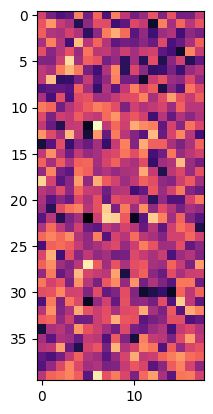

In [34]:
plt.imshow(pwise, cmap='magma')


In [34]:
import pactools

In [35]:
import numpy as np
import matplotlib.pyplot as plt

from pactools import Comodulogram, REFERENCES
from pactools import simulate_pac

In [111]:
subj_id = 'MS025'
day = 'Day1'
save_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/neural/{day}'
mne_data_reref = mne.io.read_raw_fif(f'{save_path}/bp_ref_ieeg.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS025/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 534187 =      0.000 ...  1068.374 secs
Ready.
Reading 0 ... 534187  =      0.000 ...  1068.374 secs...


In [112]:
mne_data_reref.ch_names

['lacas1-lacas2',
 'lacas2-lacas3',
 'lacas3-lacas4',
 'lacas4-lacas5',
 'lacas5-lacas6',
 'laglt1-laglt2',
 'laglt2-laglt3',
 'laglt3-laglt4',
 'laglt6-laglt7',
 'laglt7-laglt8',
 'laglt8-laglt9',
 'lcmip1-lcmip2',
 'lcmip2-lcmip3',
 'lcmip3-lcmip4',
 'lcmip4-lcmip5',
 'lcmip5-lcmip6',
 'lcmip7-lcmip10',
 'lcmip10-lcmip11',
 'lcmip13-lcmip14',
 'lhplt1-lhplt2',
 'lhplt2-lhplt3',
 'lhplt3-lhplt4',
 'lhplt4-lhplt5',
 'lhplt8-lhplt9',
 'lhplt9-lhplt10',
 'lmcms1-lmcms2',
 'lmcms2-lmcms3',
 'lmcms3-lmcms4',
 'lmcms4-lmcms5',
 'lmcms5-lmcms9',
 'lmolf1-lmolf2',
 'lmolf2-lmolf3',
 'lmolf3-lmolf4',
 'lmolf4-lmolf5',
 'lmolf5-lmolf6',
 'lmolf6-lmolf7',
 'lmolf7-lmolf8',
 'lmtpt1-lmtpt2',
 'lmtpt2-lmtpt3',
 'lmtpt5-lmtpt6',
 'lmtpt6-lmtpt7',
 'lmtpt7-lmtpt9',
 'lmtpt9-lmtpt10',
 'lpvnh1-lpvnh2',
 'lpvnh2-lpvnh3',
 'lpvnh3-lpvnh4',
 'lpvnh4-lpvnh5',
 'lpvnh5-lpvnh6',
 'lpvnh6-lpvnh7',
 'lpvnh7-lpvnh8',
 'lpvnh8-lpvnh9',
 'lpvnh9-lpvnh10',
 'lpvnh12-lpvnh13',
 'racas1-racas2',
 'racas2-racas3',


In [113]:
signal = mne_data_reref._data[0, :]

In [114]:
signal.shape

(534188,)

In [118]:
fs = mne_data_reref.info['sfreq']  # Hz
low_fq_width = 1.0  # Hz

In [119]:
low_fq_range = np.linspace(1, 10, 50)
high_fq_range = np.linspace(50,200, 30)
methods = ['canolty', 'tort',  'duprelatour','bispectrum'
]

canolty... 
tort... 
duprelatour... 
bispectrum... 


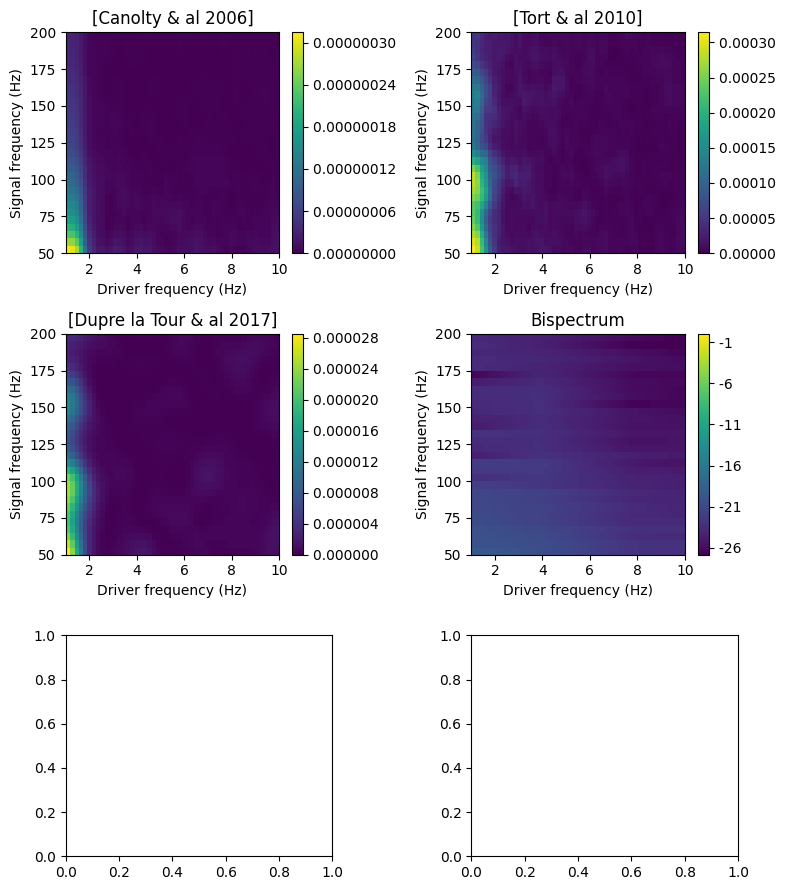

In [120]:
# Define the subplots where the comodulogram will be plotted
n_lines = 3
n_columns = int(np.ceil(len(methods) / float(n_lines)))
fig, axs = plt.subplots(
    n_lines, n_columns, figsize=(4 * n_columns, 3 * n_lines))
axs = axs.ravel()


# Compute the comodulograms and plot them
for ax, method in zip(axs, methods):
    print('%s... ' % (method, ))
    estimator = Comodulogram(fs=fs, low_fq_range=low_fq_range, high_fq_range=high_fq_range,
                             low_fq_width=low_fq_width, method=method,
                             progress_bar=False)
    estimator.fit(signal)
    estimator.plot(titles=[REFERENCES[method]], axs=[ax])

plt.show()